# Developing an age-structured model in R

In the lecture, you learned how to structure an SIR model into two age groups and how to define the force of infection in a population with age-specific mixing. In this exercise, you get to put this into practice to simulate an outbreak in R.

From the previous etivity, you will remember the structure for a model stratified into children and adults:

<img src="Graphics_and_Data/w2_nb1_model_diagram.png">

You will already be familiar with some assumptions underlying this structure. There are no arrows going from compartments 1 (children) to compartments 2 (adults), which means we assume there is no ageing in this population. Of course, this is only realistic if we are modelling an infection over a relatively short timespan, where ageing from childhood into adulthood doesn't matter. Additionally, we assume that children and adults all recover from the infection at the same rate $\gamma$.

The reason why we are stratifying the population into different age groups is because we assume age-specific mixing patterns, meaning that different ages experience different forces of infection. In our model, susceptible children experience a force of infection $\lambda_1$ and susceptible adults become infected at a rate $\lambda_2$. 

Remember, in previous models we have summarised the infection rate with the $\beta$ parameter. However, to model age-specific mixing patterns in a population, it is helpful to break $\beta$ down into its 2 key components:
- $b$, the probability of infection per contact
- $c_{ij}$, the number of contacts that a susceptible person in age group i makes with people in age group j per unit time

In this exercise, we are modelling an outbreak in a population based in the UK. Based on the Mossong contact study you covered in a previous reading, we assume that in Great Britain, children make 13 contacts per day on average, of which 7 are with other children, and that adults make 11 contacts per day on average, of which 10 are with other adults. This gives the following contact parameters:

$c_{11} = 7$  
$c_{12} = 6$  
$c_{21} = 1$  
$c_{22} = 10$  

We also assume that the probability of infection per contact, $b$, is the same for children and adults and equals 5% for the disease we are modelling, and that people remain infected on average for 5 days. The total population size is 1 million, and children make up 20% of that population.

Based on this information, write code to simulate an infection in a totally naïve (unexposed) population over the course of 3 months in the cell below, and plot the full model output. 

### Question: What was the cumulative incidence of infection during this epidemic? What proportion of those infections occurred in children?

*Hint: since this is an SIR model, you can use a simple approach to calculate the cumulative incidence.*

### Question: Which age group was most affected by the epidemic?

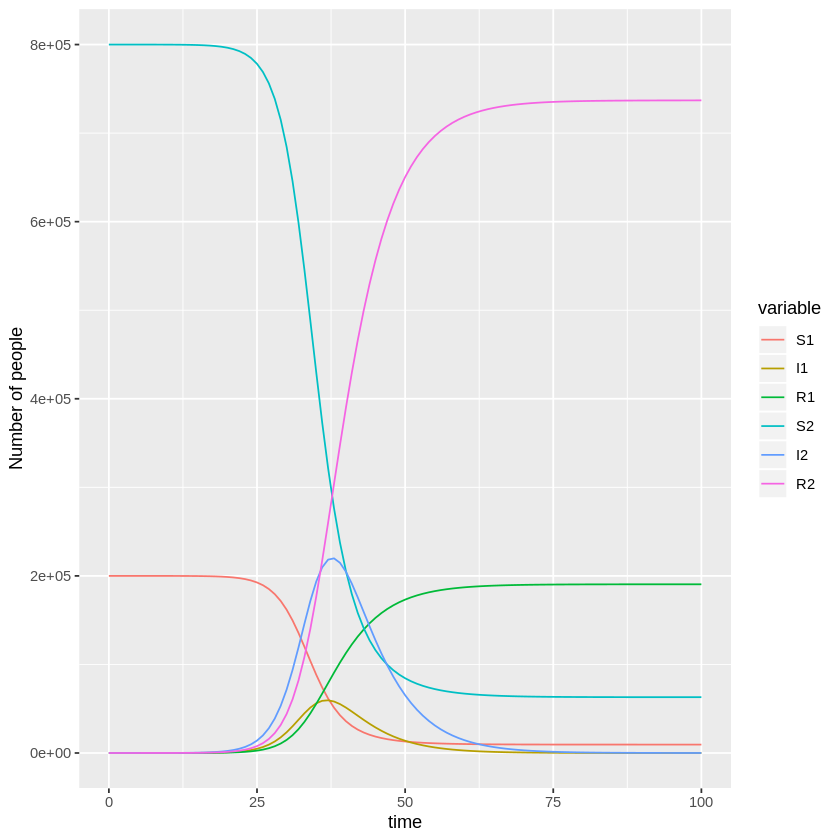

In [2]:
### YOUR CODE GOES HERE ###


library(deSolve)
library(ggplot2)
library(reshape2)

# INPUT
initial_state_values <- c(S1 = (1000000*0.2)-1,  
                          I1 = 1,       
                          R1 = 0,
                          S2=(1000000*0.8)-1,
                          I2=1,
                          R2=0)

parameters <- c(b=0.05,
                gamma = 1/5,
                c11=7,
                c12=6,
                c21=1,
                c22=10)

times <- seq(from = 0, to = 100, by = 1)

# SIR MODEL FUNCTION
sir_model <- function(time, state, parameters) {  
  
  with(as.list(c(state, parameters)), {
    
    N1<-S1+I1+R1
    N2<-S2+I2+R2
    
    lambda2 <- (b*c21*I1/N1)+(b*c22*I2/N2)
    lambda1 <- (b*c12*I2/N2)+(b*c11*I1/N1)
    
    # The differential equations
    dS1 <- -lambda1 * S1               
    dI1 <- lambda1 * S1 - gamma * I1
    dR1 <- gamma * I1  
    
    dS2 <- -lambda2 * S2               
    dI2 <- lambda2 * S2 - gamma * I2
    dR2 <- gamma * I2  
    
    # Output
    return(list(c(dS1, dI1, dR1,dS2,dI2,dR2))) 
  })
}

output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters))
                            
output_long<- melt(as.data.frame(output),id="time")
ggplot(data=output_long,
      aes(x=time,
         y=value,
         colour=variable,
         group=variable))+
         geom_line()+
         xlab("time")+
         ylab("Number of people") 

In [3]:
paste("Number susceptible at time 0:", output$S1[output$time == 0]+output$S2[output$time == 0])
paste("Number susceptible at time 100:", output$S1[output$time == 100]+output$S2[output$time == 100])
paste("Difference:",output$S1[output$time == 0]+output$S2[output$time == 0]-(output$S1[output$time == 100]+output$S2[output$time == 100]))

[1] "Number susceptible at time 0: 999998"

[1] "Number susceptible at time 100: 72506.4250497052"

[1] "Difference: 927491.574950295"

Note that there is more than one correct approach to coding this model, so don't worry if your code looks different from the solution file (as long as your reasoning and result are correct of course). We will cover another approach in the next etivity.

## Additional information: realistic contact patterns

In this exercise, we have used empirical data from the Mossong study to assign values to our contact parameters. However, it is also useful to think more generally about what makes a realistic contact pattern in human populations. 

If you think about it, it is logical that within a population, the total number of contacts made by children with adults has to be consistent with the total number of contacts made by adults with children. We can check if this is the case in our example by calculating if our contact parameters fulfill this condition:

Average daily number of contacts made by children with adults ($c_{12}$) * proportion of children in the population = average daily number of contacts made by adults with children ($c_{21}$) * proportion of adults in the population

\begin{align}
6 \times 0.2 =  1.2 \\
1 \times 0.8 = 0.8
\end{align}

... which is approximately the same, given that we have rounded the average number of contacts to whole numbers for simplicity in this example!